In [1]:
# 2017-10-08 LSTM-2
# переработан ввод на последовательности 

In [2]:
from __future__ import division
import sys, os, datetime
import pandas as pd
from collections import Counter
import functools
#import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as skm
import sklearn.model_selection as skms
import pymorphy2
import h5py

In [3]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras.preprocessing.text
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [4]:
#dftrain, dftest = pd.read_csv("../Data/train_task1_latest.csv"), pd.read_csv("../Data/test_task1_latest.csv")
dftrain, dftest = pd.read_csv("../Work/train_task1_lemma.csv"), pd.read_csv("../Work/test_task1_lemma.csv")

In [5]:
dftrain.shape, dftest.shape, dftrain.columns

((119398, 13),
 (74294, 12),
 Index([u'paragraph_id', u'question_id', u'paragraph', u'question', u'target',
        u'paragraphL', u'questionL', u'paragraphLS', u'questionLS',
        u'paragraphLX', u'questionLX', u'paragraphLSX', u'questionLSX'],
       dtype='object'))

In [16]:
num_rows  = len(dftrain) #10000 #00
num_voc   = 500
max_len   = 350

train_x0  = dftrain.paragraphLS[:num_rows].tolist()
train_x1  = dftrain.questionLS[:num_rows].tolist()
train_y   = dftrain.target[:num_rows]

test_x0   = dftest.paragraphLS[:num_rows].tolist()
test_x1   = dftest.questionLS[:num_rows].tolist()

train_s0  = [keras.preprocessing.text.one_hot(xx,num_voc) for xx in train_x0]
train_s1  = [keras.preprocessing.text.one_hot(xx,num_voc) for xx in train_x1]

test_s0   = [keras.preprocessing.text.one_hot(xx,num_voc) for xx in test_x0]
test_s1   = [keras.preprocessing.text.one_hot(xx,num_voc) for xx in test_x1]

train_ss0 = keras.preprocessing.sequence.pad_sequences(train_s0, maxlen=max_len)
train_ss1 = keras.preprocessing.sequence.pad_sequences(train_s1)

test_ss0  = keras.preprocessing.sequence.pad_sequences(test_s0, maxlen=max_len)
test_ss1  = keras.preprocessing.sequence.pad_sequences(test_s1)


#print train_s0[0], train_s1[0], '\n', train_ss0.shape, train_ss1.shape, '\n', train_ss0[0,:], '\n', train_ss1[0,:]
print train_ss0.shape, train_ss1.shape, 1.0-train_y.mean(), test_ss0.shape, test_ss1.shape


(119398, 350) (119398, 60) 0.714928223253 (74294, 350) (74294, 301)


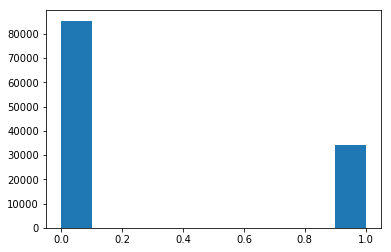

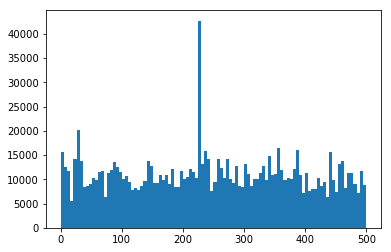

In [17]:
plt.hist(train_y.values.flatten(),bins=10); plt.show()
plt.hist(train_ss1[train_ss1>0].flatten(),bins=100); plt.show()

In [18]:
'''
import keras.layers.merge
max_features0 = train_ss0.shape[1]
max_features1 = train_ss1.shape[1]
#model = Sequential()
#model.add(Embedding(max_features, 256))
#model.add(Input(shape=[max_feature], dtype='float32'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

K.clear_session()

i0 = Input(shape=[max_features]) #, dtype='float32')
x0 = Embedding(max_features, 16)(i0)
x0 = LSTM(128,dropout=0.2)(x0)

i1 = Input(shape=[max_features]) #, dtype='float32')
x1 = Embedding(max_features, 8)(i1)
x1 = LSTM(128,dropout=0.2)(x1)

#xx = keras.layers.concatenate([x0, x1])
xx = keras.layers.Add()([x0, x1])

xx = Dense(16, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
xx = Dense(64, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(128, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
##xx = Dense(256, activation='relu')(xx)
xx = Dropout(0.25)(xx)
o = Dense(2, activation='softmax')(xx)
#o = Dense(1, activation='sigmoid')(xx)

model = Model(inputs=[i0,i1], outputs=o)

model.summary()

model.compile(loss='binary_crossentropy', #'mae', #'mse', #'binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy','mse'])
'''

"\nimport keras.layers.merge\nmax_features0 = train_ss0.shape[1]\nmax_features1 = train_ss1.shape[1]\n#model = Sequential()\n#model.add(Embedding(max_features, 256))\n#model.add(Input(shape=[max_feature], dtype='float32'))\n#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))\n#model.add(Dense(50, activation='relu'))\n#model.add(Dense(5, activation='sigmoid'))\n\nK.clear_session()\n\ni0 = Input(shape=[max_features]) #, dtype='float32')\nx0 = Embedding(max_features, 16)(i0)\nx0 = LSTM(128,dropout=0.2)(x0)\n\ni1 = Input(shape=[max_features]) #, dtype='float32')\nx1 = Embedding(max_features, 8)(i1)\nx1 = LSTM(128,dropout=0.2)(x1)\n\n#xx = keras.layers.concatenate([x0, x1])\nxx = keras.layers.Add()([x0, x1])\n\nxx = Dense(16, activation='relu')(xx)\n#xx = Dropout(0.25)(xx)\nxx = Dense(64, activation='relu')(xx)\n#xx = Dropout(0.25)(xx)\n#xx = Dense(128, activation='relu')(xx)\n#xx = Dropout(0.25)(xx)\n##xx = Dense(256, activation='relu')(xx)\

In [23]:
max_features0 = train_ss0.shape[1]
max_features1 = train_ss1.shape[1]
max_lstm      = max(train_ss0.shape[1],train_ss1.shape[1])
#model = Sequential()
#model.add(Embedding(max_features, 256))
#model.add(Input(shape=[max_feature], dtype='float32'))
#model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2,return_sequences=True,input_shape=[None,6]))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(5, activation='sigmoid'))

K.clear_session()

i0 = Input(shape=[max_features0]) #, dtype='float32')
x0 = Embedding(max_features0,max_features0)(i0)
x0,state_h,state_c = LSTM(max_lstm,dropout=0.2,recurrent_dropout=0.2,return_state=True)(x0)

i1 = Input(shape=[max_features1]) #, dtype='float32')
x1 = Embedding(max_features1,max_features1)(i1)
xx,_,_ = LSTM(max_lstm,dropout=0.2,recurrent_dropout=0.2,return_state=True)(x1,initial_state=[state_h,state_c])

#xx = keras.layers.concatenate([x0, x1])

#xx = Dense(128, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(64, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(32, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(16, activation='relu')(xx)
#xx = Dropout(0.25)(xx)
#xx = Dense(32, activation='relu')(xx)
#xx = Dropout(0.5)(xx)
##xx = Dense(256, activation='relu')(xx)
###xx = Dropout(0.25)(xx)
#o = Dense(2, activation='softmax')(xx)
o = Dense(1, activation='sigmoid')(xx)

model = Model(inputs=[i0,i1], outputs=o)

model.summary()

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #, clipnorm=0.2)
model.compile(loss='binary_crossentropy', #'mae', #'mse', #'binary_crossentropy',
              optimizer='adam', #sgd, #'RMSprop', #sgd, #'adam',
              metrics=['binary_accuracy','accuracy','mse'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 350)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 350, 350)      122500      input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 60, 60)        3600        input_2[0][0]                    
___________________________________________________________________________________________

In [24]:
if 0 :
    sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #, clipnorm=0.2)
    model.compile(loss='binary_crossentropy', #'mae', #'mse', #'binary_crossentropy',
                  optimizer=sgd, #'RMSprop', #sgd, #'adam',
                  metrics=['binary_accuracy','accuracy','mse'])

In [25]:
batch_size   = 256  #128 #256 #512 #1024 #+512 #+1024 #+512
print (datetime.datetime.now())

reduce_lr1     = ReduceLROnPlateau(monitor='loss', factor=0.1,patience=3, min_lr=0.0000001,verbose=1)
early_stopping = EarlyStopping(monitor='loss', patience=8,min_delta=0.0001,verbose=1)

#filepath="../Temp/LSTM2--val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
filepath="../Temp/LSTM2-best.hdf5"
checkpoint1 = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

hist = model.fit([train_ss0,train_ss1], train_y,
                  batch_size=batch_size,
                  #shuffle=True,
                  epochs=150,
                  initial_epoch=0,
                  callbacks=[reduce_lr1, early_stopping, checkpoint1],
                  #validation_data=([x_train[-200:],z_train[-200:],a_train[-200:]], y_train[-200:]),
                  verbose=2)
print (datetime.datetime.now())

2017-10-09 02:23:17.195701
Epoch 1/150
Epoch 00000: acc improved from -inf to 0.79758, saving model to ../Temp/LSTM2-best.hdf5
474s - loss: 0.4321 - binary_accuracy: 0.7976 - acc: 0.7976 - mean_squared_error: 0.1408
Epoch 2/150
Epoch 00001: acc improved from 0.79758 to 0.84632, saving model to ../Temp/LSTM2-best.hdf5
468s - loss: 0.3092 - binary_accuracy: 0.8463 - acc: 0.8463 - mean_squared_error: 0.1018
Epoch 3/150
Epoch 00002: acc did not improve
467s - loss: 0.3266 - binary_accuracy: 0.8400 - acc: 0.8400 - mean_squared_error: 0.1069
Epoch 4/150
Epoch 00003: acc improved from 0.84632 to 0.86313, saving model to ../Temp/LSTM2-best.hdf5
467s - loss: 0.2784 - binary_accuracy: 0.8631 - acc: 0.8631 - mean_squared_error: 0.0913
Epoch 5/150
Epoch 00004: acc improved from 0.86313 to 0.87714, saving model to ../Temp/LSTM2-best.hdf5
467s - loss: 0.2572 - binary_accuracy: 0.8771 - acc: 0.8771 - mean_squared_error: 0.0834
Epoch 6/150
Epoch 00005: acc improved from 0.87714 to 0.88382, saving mode

In [281]:
#hist.__dict__

In [26]:
model.load_weights('../Temp/LSTM2-best.hdf5')

In [27]:
train_xp = model.predict([train_ss0[:num_rows],train_ss1[:num_rows]],batch_size=batch_size)

In [28]:
skm.accuracy_score(train_y[:num_rows],train_xp>0.5), skm.roc_auc_score(train_y[:num_rows],train_xp)

(0.93241930350592139, 0.98079748944573342)

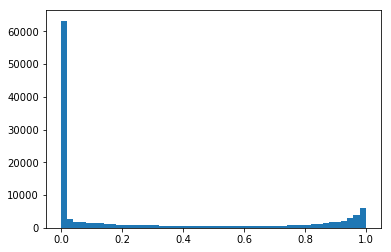

In [29]:
hh=plt.hist(train_xp.flatten(),bins=50); plt.show()

In [31]:
test_xp = model.predict([test_ss0[:num_rows],test_ss1[:num_rows,:60]],batch_size=batch_size)

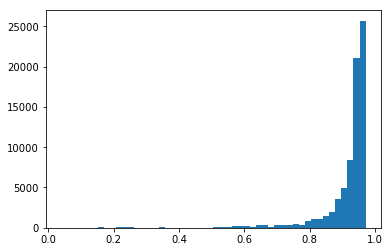

In [32]:
hh=plt.hist(test_xp.flatten(),bins=50); plt.show()

In [36]:
dfresult = dftest[['paragraph_id', 'question_id']].copy()
dfresult['prediction'] = test_xp
dfresult[['paragraph_id', 'question_id', 'prediction']].to_csv("../Result/prediction-2017-10-09-15-25-lstm.csv", index=False)

In [51]:
xx = dftest.paragraph[0]
xxx = xx.split('.')
len(xxx)
for xxxx in xxx :
    print (xxxx)

Передний мозг сильно развит, это самая большая часть головного мозга
 Кора переднего мозга у птиц выражена лучше, чем у пресмыкающихся, но её слой довольно тонок
 Хорошо развиты полосатые тела — главная часть переднего мозга, в которых расположены центры регуляции зрения, движения и т
 д
 Обонятельные доли малы и тесно примыкают к большим полушариям, поэтому способность птиц к восприятию запахов ограничена
 У птиц, питающихся падалью, обонятельные доли развиты гораздо лучше
 Полушария передней части мозга гладкие, без извилин и по сравнению с млекопитающими относительно невелики
 В их функцию входит управление поведением, ориентация в пространстве, употребление пищи, спаривание и способность строить гнёзда
 По современным взглядам, значительную часть больших полушарий у птиц занимает сложно дифференцированный паллиум (лат
 pallium)
 Ранее большая его часть принималась за производные стриатума
 У птиц паллиум содержит участки, гомологичные слоям неокортекса млекопитающих, но располагают

In [184]:
import nltk, re
xx = dftrain.paragraphLS[:num_rows].tolist()
#print(type(xx),unicode(xx[0],'utf-8'))

##ff=nltk.probability.FreqDist(xx[0].decode('utf-8'))
##ff=nltk.probability.FreqDist(unicode(xx[0],'utf-8'),unicode_)

ff=nltk.probability.FreqDist()

for ss in xx :
    for ww in re.findall("\w+", ss.decode('utf-8'),re.UNICODE) :
        ff[ww] +=1


#for ww,cc in ff.most_common(50) : print(ww,cc)

In [181]:
for ww,cc in ff.most_common(50) :
    print ww,cc

год 134808
который 84027
свой 59027
это 55298
время 46071
мочь 40857
также 33663
весь 33155
являться 28849
её 27409
система 25191
человек 25005
например 23112
опера 22024
вид 21269
стать 19141
форма 19004
иметь 18984
век 18482
образ 18071
ещё 17594
друг 17112
новый 17066
французский 16918
некоторый 16481
течение 16471
часть 16230
большой 16189
отношение 15804
мир 14612
язык 14559
отец 14396
команда 14138
страна 13909
право 13904
использоваться 13754
иван 13682
сын 13438
фильм 13414
высокий 13341
4 13260
1 13211
несколько 13026
ряд 12871
разум 12618
двигатель 12602
называть 12460
самый 12431
писатель 12080
происходить 11915
